## **Introduction**
#### This notebook explores the solution for the Kaggle Competition [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview)

### **Problem Description**
#### We are provided with a Time Series Dataset containing of daily sales data. Our goal is to prdict total sales for every product and store in the next month.

### **Dataset**
#### Dataset can be aquired from [here](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

### **Approach**
#### We are given a time series dataset, to work on this, two approches mainly a regular LSTM model and a hybrid CNN LSTM model have been discussed in this notebook.
#### It is based on the learnings from: [Deep Learning for time series forecasting](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)

### **Results from present analysis**
| Model   | Accuracy   | Loss   | Mean Squared Error |
|---|---|---|---|
| Regular LSTM  | 91.97%  | 0.375  | 0.612 |
| Hybrid CNN LSTM   |  92.13% | 0.378  |  0.615 | 


All these results are for validation dataset.
The model was trained for 10 epochs, with Adam as the optimizer and a learning rate of 0.0003. This particular set of hyperparameters tends to give best results compared to other sets experimented with. 

### Dependencies


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")


# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

Using TensorFlow backend.


### Acquiring the dataset directly through Kaggle API


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
# Here I uploaded my JSON key for the API
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.86MB/s]
  0% 0.00/1.50M [00:00<?, ?B/s]
100% 1.50M/1.50M [00:00<00:00, 101MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 3.00MB/s]
  0% 0.00/469k [00:00<?, ?B/s]
100% 469k/469k [00:00<00:00, 201MB/s]
  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 144MB/s]
 70% 9.00M/12.9M [00:00<00:00, 31.8MB/s]
100% 12.9M/12.9M [00:00<00:00, 37.1MB/s]


### Reading train and test data



In [0]:
train_data=pd.read_csv('sales_train.csv.gz',compression='gzip',low_memory=False)

test_data=pd.read_csv('test.csv.gz',compression='gzip',low_memory=False)



#### Visualizing Training Data




In [30]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Visualizing Testing Data





In [31]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [0]:
''' The feature "date" is an object as of now, in orfer to manipulate it, we need to convert it into date time format.'''

train_data['date'] = pd.to_datetime(train_data['date'], format='%d.%m.%Y')

In [33]:
train_data.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,2015-10-10,33,25,7409,299.0,1.0
2935845,2015-10-09,33,25,7460,299.0,1.0
2935846,2015-10-14,33,25,7459,349.0,1.0
2935847,2015-10-22,33,25,7440,299.0,1.0
2935848,2015-10-03,33,25,7460,299.0,1.0


In [34]:
''' Finding the minimum and maximum of the dates in order to know the whole time period'''
print(min(train_data['date']))
print(max(train_data['date']))


2013-01-01 00:00:00
2015-10-31 00:00:00


### Exploratory Data Analysis


In [0]:
def eda(df):
  '''
  Arguments: dataframe
  Function: Tabulates different properties of data for analysis
  Output: Prints records, description, columns and missing values
  
  '''

  print("First 5 records")
  print(df.head(5))

  print("Description")
  print(df.describe())

  print("Columns")
  print(df.columns)

  print("Shape of data")
  print(df.shape)

  print("Missing values")
  print(df.isnull().sum())


In [36]:
eda(train_data)

First 5 records
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0
Description
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1

### Feature Engineering


1. First of all, let's just keep those "shop ids" and "item ids", that are there in the test set. This will give more accurate results
2. The feature "int_cnt_day" will be used as a univariate time series, hence all other features are being dropped
3. We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's aggregate the data by month.
4. Test set distributions for "item_cnt" seem to lie in the range 0 to 20, and therefore we will keep this range only for training data too.





In [0]:
test_shop_ids = test_data['shop_id'].unique()
test_item_ids = test_data['item_id'].unique()

# Only shops that exist in test set.
train_data = train_data[train_data['shop_id'].isin(test_shop_ids)]

# Only items that exist in test set.
train_data = train_data[train_data['item_id'].isin(test_item_ids)]

In [37]:
train_monthly = train_data[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)
train_monthly.head(10).T

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
shop_id,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_id,32.0,33.0,35.0,43.0,51.0,61.0,75.0,88.0,95.0,96.0
item_cnt,6.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0
item_cnt_month,10.0,3.0,14.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN


In [38]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,1596746.0,14.665884,9.545273,0.0,6.0,14.0,23.0,33.0
shop_id,1596746.0,32.811282,16.543835,0.0,21.0,31.0,47.0,59.0
item_id,1596746.0,10687.982293,6233.717097,0.0,5060.0,10502.0,16060.0,22169.0
item_cnt,1596746.0,1.894908,2.087729,0.0,1.0,1.0,2.0,20.0
item_cnt_month,1173014.0,1.891284,1.964539,0.0,1.0,1.0,2.0,20.0


#### Time Series Processing


##### Since we only need the "item_cnt" feature as a series, we can get that by using a pivot operation. 
##### This will also replace all the missing months from each "shop_id" and "item_id" with 0.



In [40]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_series.tail()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
423727,59,22154,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
423728,59,22155,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
423729,59,22162,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,1,1,0,0,1,0,0
423730,59,22164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,2,0,0,1,0,0,0
423731,59,22167,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Sub-sampling train set to get only the last year of data and reduce training time. 
##### We currently have for each unique pair of "shop_id" and "item_id", but we will subsample it to generate multiple series of size 12 (1 year) for each unique pair 



In [41]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Dropping identifier columns as we don't need them anymore.


In [0]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

##### Train and validation sets.


In [0]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

##### Reshape data as Time Series Feature Set
##### Time-series shape (data points, time-steps, features).
##### This is important since the LSTM model we will be developing accepts 3 dimensional input.


In [44]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))
print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (762717, 12, 1)
Validation set reshaped (84747, 12, 1)


### Building Models


#### First approach will be a regular LSTM (Long Short Term Memory Cells) model. 
##### The intuition behind this is that, since we have a time series dataset, and we want to predict the next sequence(next month's sales), given a particular sequence(current's months sales), a LSTM model might work well. 
##### LSTM models have a nice feature of capturing and sustaining long term dependencies in sequential data, as compared to regular Recurrent Neural Networks 

#### Model description:

##### We will define the number of input time steps as 3 and the number of features as 1 via the input_shape argument on the first hidden layer.

##### We will use one LSTM layer to process each input sub-sequence of 3 time steps, followed by a Dense layer to interpret the summary of the input sequence. The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

##### A detailed tutorial for using LSTM models for time series prediction is given here: https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/


##### Setting hyperparameters for our models



In [0]:
epochs = 10
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 12, 10)            480       
_________________________________________________________________
lstm_6 (LSTM)                (None, 12, 6)             408       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1)                 32        
____________________________

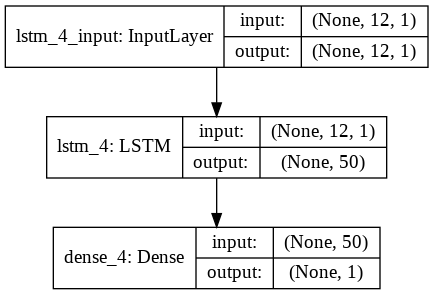

In [48]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam,metrics = ['accuracy'])
model_lstm.summary()

plot_model(model_lstm, show_shapes=True, to_file='regular_lstm.png')

##### Fit model

In [49]:
lstm_history = model_lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch, validation_data=(X_valid, Y_valid), verbose=2)

Train on 762717 samples, validate on 84747 samples
Epoch 1/10
 - 75s - loss: 0.3808 - acc: 0.9195 - val_loss: 0.3780 - val_acc: 0.9198
Epoch 2/10
 - 74s - loss: 0.3734 - acc: 0.9192 - val_loss: 0.3758 - val_acc: 0.9190
Epoch 3/10
 - 74s - loss: 0.3725 - acc: 0.9194 - val_loss: 0.3754 - val_acc: 0.9202
Epoch 4/10
 - 74s - loss: 0.3718 - acc: 0.9195 - val_loss: 0.3765 - val_acc: 0.9201
Epoch 5/10
 - 73s - loss: 0.3713 - acc: 0.9195 - val_loss: 0.3762 - val_acc: 0.9204
Epoch 6/10
 - 74s - loss: 0.3710 - acc: 0.9196 - val_loss: 0.3762 - val_acc: 0.9204
Epoch 7/10
 - 74s - loss: 0.3703 - acc: 0.9199 - val_loss: 0.3759 - val_acc: 0.9205
Epoch 8/10
 - 74s - loss: 0.3700 - acc: 0.9199 - val_loss: 0.3755 - val_acc: 0.9203
Epoch 9/10
 - 73s - loss: 0.3702 - acc: 0.9198 - val_loss: 0.3740 - val_acc: 0.9210
Epoch 10/10
 - 73s - loss: 0.3698 - acc: 0.9200 - val_loss: 0.3755 - val_acc: 0.9197


#### Model evaluation



In [54]:
# Evaluating loss, accuracy
score_lstm = model_lstm.evaluate(X_valid,Y_valid)
score_lstm

84747/84747 [==============================] - 28s 333us/step


[0.3755022277545913, 0.9197257720037287]

#### **Result for 10 epochs**

##### **Loss: 0.375**
##### **Accuracy: 91.97%**





##### Comparing RMSE Score for training and validation data


In [114]:
lstm_train_pred = model_lstm.predict(X_train)
lstm_val_pred = model_lstm.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 0.6089099063317909
Validation rmse: 0.6127823677981545


#### Our second approach is going to be a Time Distributed CNN LSTM Model

#### Model description

##### The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model.
##### When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such,we will split each sample into 2 subsequences of 2 times per subsequence.

##### The CNN will be defined to expect 2 time steps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction.

##### The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse’) loss function.


In [50]:
subsequences = 2
timesteps = X_train.shape[1]//subsequences
X_train_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_sub.shape)
print('Validation set shape', X_valid_sub.shape)

Train set shape (762717, 2, 6, 1)
Validation set shape (84747, 2, 6, 1)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, None, 6, 64)       128       
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 192)         0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                48600     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 48,779
Trainable params: 48,779
Non-trainable params: 0
_________________________________________________________________


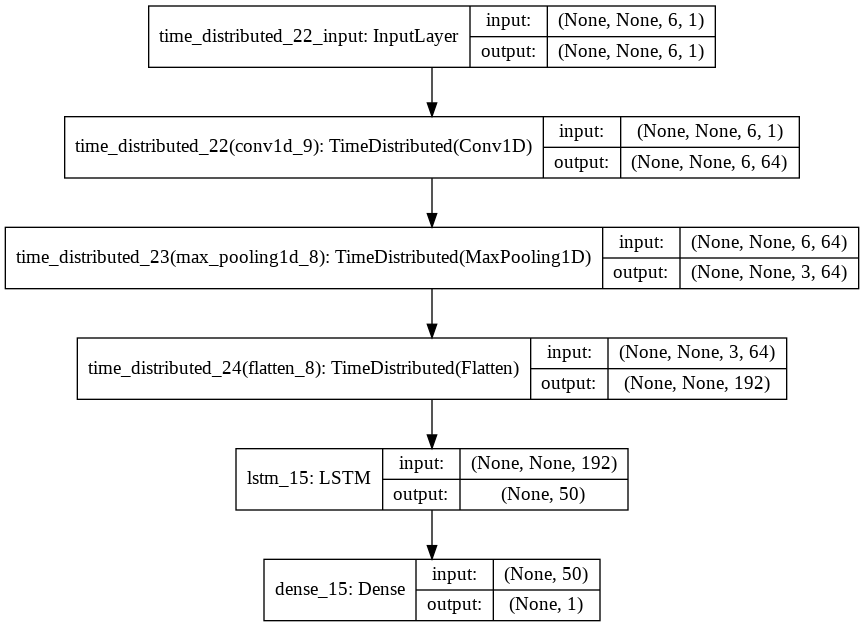

In [85]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_sub.shape[2], X_train_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam,metrics=['accuracy'])
model_cnn_lstm.summary()
plot_model(model_cnn_lstm, show_shapes=True, to_file='cnn_lstm.png')

In [77]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_sub, Y_train, validation_data=(X_valid_sub, Y_valid), epochs=epochs, verbose=2)

Train on 762717 samples, validate on 84747 samples
Epoch 1/10
 - 197s - loss: 0.3832 - acc: 0.9188 - val_loss: 0.3838 - val_acc: 0.9171
Epoch 2/10
 - 195s - loss: 0.3803 - acc: 0.9190 - val_loss: 0.3817 - val_acc: 0.9197
Epoch 3/10
 - 195s - loss: 0.3789 - acc: 0.9192 - val_loss: 0.3809 - val_acc: 0.9201
Epoch 4/10
 - 195s - loss: 0.3779 - acc: 0.9194 - val_loss: 0.3805 - val_acc: 0.9208
Epoch 5/10
 - 195s - loss: 0.3775 - acc: 0.9198 - val_loss: 0.3802 - val_acc: 0.9211
Epoch 6/10
 - 195s - loss: 0.3775 - acc: 0.9195 - val_loss: 0.3794 - val_acc: 0.9204
Epoch 7/10
 - 195s - loss: 0.3765 - acc: 0.9196 - val_loss: 0.3797 - val_acc: 0.9200
Epoch 8/10
 - 195s - loss: 0.3762 - acc: 0.9194 - val_loss: 0.3795 - val_acc: 0.9213
Epoch 9/10
 - 195s - loss: 0.3758 - acc: 0.9197 - val_loss: 0.3789 - val_acc: 0.9194
Epoch 10/10
 - 195s - loss: 0.3759 - acc: 0.9197 - val_loss: 0.3790 - val_acc: 0.9214


In [78]:
score_cnn_lstm = model_cnn_lstm.evaluate(X_valid_sub,Y_valid)
score_cnn_lstm

84747/84747 [==============================] - 7s 80us/step


[0.3789629117040016, 0.9213777478848809]

#### **Results**
##### **Accuracy: 92.13%**
##### **Loss: 0.378**


#### Comparing RMSE for training and testing data


In [117]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_sub)
cnn_lstm_val_pred = model_cnn_lstm.predict(X_valid_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_val_pred)))

Train rmse: 0.6104321160298515
Validation rmse: 0.6158445402175854


### Visualizing raining and testing losses in the form of mean squared error



Text(0, 0.5, 'MSE')

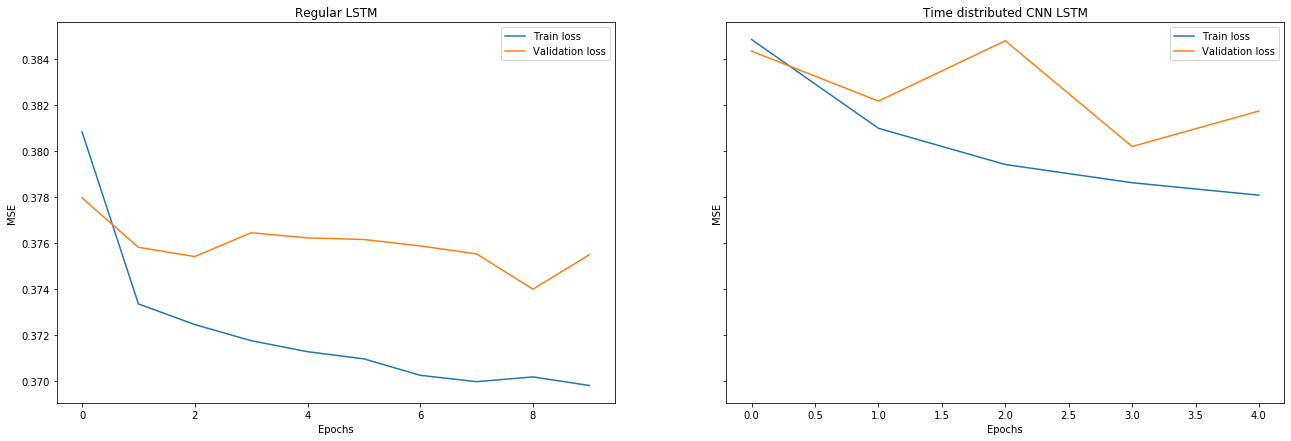

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax2.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('Time distributed CNN LSTM')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

#### Preparing test data to make predictions on it 


##### We will first visualise the monthly sales



In [64]:
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test_data, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Since, we subsampled our data to look at previous one year only to predict future sales, let's fetch that range only 


In [65]:
X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33
0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# reshaping it to be fed into an LSTM
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(214200, 12, 1)


In [0]:
# making predictions with lstm model
lstm_test_pred = model_lstm.predict(X_test_reshaped)

In [70]:
# clipping predictions in the range 0 to 20, since that is the distribution range in testing data
lstm_test_pred = lstm_test_pred.clip(0,20)
# creating dataframe with required columns 
submission_lstm = pd.DataFrame({'ID':test_data['ID'],'item_cnt_month':lstm_test_pred.ravel()})
# creating csv file from dataframe
submission_lstm.to_csv('submission_lstm.csv',index = False)
submission_lstm

,ID,item_cnt_month
0,0,0.496760
1,1,0.038354
2,2,0.820674
3,3,0.074092
4,4,0.038354
...,...,...
214195,214195,0.267044
214196,214196,0.038354
214197,214197,0.011252
214198,214198,0.038354


#### Now that we are done saving our submission, let's save the modle weights too, for making predictions in future.


In [0]:
with open("model_lstm.json", "w") as file:
    file.write(model_lstm.to_json())
model_lstm.save_weights("weights_pfs_lstm.h5")

In [0]:
model_lstm.load_weights("weights_pfs_lstm.h5")

In [0]:
files.download('submission_lstm.csv')

In [0]:
files.download('weights_pfs_lstm.h5')

##### Prediction using CNN LSTM Model


In [0]:
subsequences = 2
timesteps = X_test_reshaped.shape[1]//subsequences
X_test_sub = X_test_reshaped.reshape((X_test_reshaped.shape[0], subsequences, timesteps, 1))



In [0]:
cnn_lstm_test_pred = model_cnn_lstm.predict(X_test_sub)

In [88]:
# clipping predictions in the range 0 to 20, since that is the distribution range in testing data
cnn_lstm_test_pred = cnn_lstm_test_pred.clip(0,20)
# creating dataframe with required columns 
submission_cnn_lstm = pd.DataFrame({'ID':test_data['ID'],'item_cnt_month':cnn_lstm_test_pred.ravel()})
# creating csv file from dataframe
submission_cnn_lstm.to_csv('submission_cnn_lstm.csv',index = False)
submission_cnn_lstm

,ID,item_cnt_month
0,0,0.174926
1,1,0.000000
2,2,0.030774
3,3,0.021159
4,4,0.000000
...,...,...
214195,214195,0.121636
214196,214196,0.000000
214197,214197,0.016149
214198,214198,0.000000


#### Loading weight files


In [0]:
with open("model_cnn_lstm.json", "w") as file:
    file.write(model_cnn_lstm.to_json())
model_cnn_lstm.save_weights("weights_pfs_cnn_lstm.h5")

In [0]:
model_cnn_lstm.load_weights("weights_pfs_cnn_lstm.h5")

In [0]:
files.download('submission_cnn_lstm.csv')

In [0]:
files.download('weights_pfs_cnn_lstm.h5')

#### Both these "csv" files have been submitted to the Kaggle Competition



### Further experiments
#### Hyperparameter tuning for hybrid CNN LSTM Model




In [0]:
# set 1
epochs = 5
batch = 256
lr = 0.0001
adam = optimizers.Adam(lr)

#### **Results**
##### Accuracy: 91.62%
##### Loss: 0.382


In [0]:
# set 2
epochs = 5
batch = 256
lr = 0.001
adam = optimizers.Adam(lr)

#### **Results**
##### Accuracy: 91.69%
##### Loss: 0.384


#### More tuning can be done like this


### Inspirational Work
#### Following are some of the helpful resources:


1. https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/
2. https://www.kaggle.com/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook
3. https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders/output
